# Análise dos dados de cadastro de filiados aos partidos políticos na Paraíba.

### Aluna: Aurenívia Gomes da Costa

### 1. Introdução

#### 1.1 Motivação
A Principal motivação deste projeto vém do fato do ano atual (2020) ser um ano eleitoral. então estudar o comportamento dos eleitores, em particular, dos filiados aos partidos políticos, se torna uma tarefa relevante.

#### 1.2 Objetivos da Análise

O Objetivo principal desta análisa é entender os padrões de filiação e desfiliação dos filiados dos partidos políticos na Paraíba. e se existem anomalias correlacionadas à eventos políticos, como o impeachment da Presidenta Dilma Rousseff em 2016.

In [1]:
"""
essa célula deve ser executada para baixar os módulos que serão utilizados
neste projeto
"""
%pip install get_wayback_machine pandas numpy tqdm seaborn;

### 2. Dados Usados:
Oficialmente, os dados utilizados estavam disponíveis no [portal de acesso à dados do governo](https://dados.gov.br/dataset/filiados-partidos-politicos), mas devido ao período eleitoral, estes dados se tornaram indisponíveis. sendo assim, foi utilizada uma cópia arquivada obtida através do [Wayback Machine](https://archive.org/web/).


Os dados estão separados em centenas de arquivos compactados, que seguem o padrão: 

filiados_{**partido**}_{**estado**}.zip

Para os propósitos deste estudo, serão filtrados apenas os referentes ao estado da paraíba.


In [2]:
""" Download e extração dos arquivos:
nessa passo, iremos baixar os arquivos do dataset via wayback machine 
e extrair seus conteúdos.
"""

import requests, zipfile, io, os
import get_wayback_machine
from tqdm.notebook import tqdm # imprimir barra de progresso

# Listamos todos os Partidos e Estados

PARTIDOS = ['dem','pc_do_b','pcb','pco','pdt','phs','pmdb','pmn','pp','ppl',
            'pps','pr','prb','prtb','psb','psc','psd','psdb','psdc','psl',
            'psol','pstu','pt','pt_do_b','ptb','ptc','ptn','pv']

# para esse momento, escolhendo o estado do paraíba "pb"
urls = [f'http://agencia.tse.jus.br/estatistica/sead/eleitorado/filiados/uf/filiados_{partido}_pb.zip' \
        for partido in PARTIDOS]

""" 
Executamos um laço para baixar os dados refentes a cada partido, 
extraí-los e salvá-los na pasta atual.
"""

acertos, erros = 0,0 # verificar os acertos e erros

for url in tqdm(urls):
  r = get_wayback_machine.get(url)
  if r is not None and r.status_code == 200:
    z = zipfile.ZipFile(io.BytesIO(r.content))\
    .extractall('filiados/')
    acertos += 1;
  else:
    print(f"erro {url}")
    erros += 1;

print(f"arquivos baixados com sucesso {acertos}, erros: {erros}");

"""
Cria-se uma lista de caminhos, para que esses arquivos possam ser importados
no Pandas.
"""
CAMINHO = '/content/filiados/aplic/sead/lista_filiados/uf/'
arquivos = []

for _, __, files in os.walk(CAMINHO):
  for file in files:
    if file.endswith(".csv"):
      arquivos.append(CAMINHO + file)

print("arquivos extraídos e listados com sucesso");


arquivos baixados com sucesso 28, erros: 0
arquivos extraídos e listados com sucesso


### 2.1 Preparação Inicial dos Dados

Para começarmos o estudo desses dados, precisamos primeiro identificar os campos disponíveis.
para isso, abrimos uma pequena amostra dos arquivos e listamos seus campos e colunas

In [3]:
import pandas as pd 
# o arquivo csv não é bem padronizado:
# é codificado em formato windows e seus separadores são ponto-e-virgula
teste = pd.read_csv(arquivos[0],encoding='latin-1', sep=";")
#verificar tipos de dados
teste.dtypes

DATA DA EXTRACAO           object
HORA DA EXTRACAO           object
NUMERO DA INSCRICAO         int64
NOME DO FILIADO            object
SIGLA DO PARTIDO           object
NOME DO PARTIDO            object
UF                         object
CODIGO DO MUNICIPIO         int64
NOME DO MUNICIPIO          object
ZONA ELEITORAL              int64
SECAO ELEITORAL             int64
DATA DA FILIACAO           object
SITUACAO DO REGISTRO       object
TIPO DO REGISTRO           object
DATA DO PROCESSAMENTO      object
DATA DA DESFILIACAO        object
DATA DO CANCELAMENTO       object
DATA DA REGULARIZACAO     float64
MOTIVO DO CANCELAMENTO     object
dtype: object

In [4]:
teste.head(3)

,DATA DA EXTRACAO,HORA DA EXTRACAO,NUMERO DA INSCRICAO,NOME DO FILIADO,SIGLA DO PARTIDO,NOME DO PARTIDO,UF,CODIGO DO MUNICIPIO,NOME DO MUNICIPIO,ZONA ELEITORAL,SECAO ELEITORAL,DATA DA FILIACAO,SITUACAO DO REGISTRO,TIPO DO REGISTRO,DATA DO PROCESSAMENTO,DATA DA DESFILIACAO,DATA DO CANCELAMENTO,DATA DA REGULARIZACAO,MOTIVO DO CANCELAMENTO
0,05/11/2018,01:28:36,30319551228,ADRIANO DA SILVA ROCHA,PDT,PARTIDO DEMOCRÁTICO TRABALHISTA,PB,19658,CABEDELO,57,88,02/10/2003,SUB JUDICE,OFICIAL,15/04/2016,NaN,NaN,NaN,NaN
1,05/11/2018,01:28:36,30319551228,ADRIANO DA SILVA ROCHA,PDT,PARTIDO DEMOCRÁTICO TRABALHISTA,PB,19658,CABEDELO,57,88,16/07/2003,SUB JUDICE,OFICIAL,15/04/2016,NaN,NaN,NaN,NaN
2,05/11/2018,01:28:36,24292741252,MARIA ALZENEIDE ALVES,PDT,PARTIDO DEMOCRÁTICO TRABALHISTA,PB,20001,SANTA CECÍLIA,18,53,04/07/2003,SUB JUDICE,OFICIAL,15/04/2016,NaN,NaN,NaN,NaN


Através dessa exploração inicial, pode-se notar que existem dados faltantes. (em campos de data, por ex: data de desfiliação, motivo de cancelamento, em filiações ainda ativas, etc.)

### 2.2 - Pré-Processamento e Limpeza dos dados

Para Trabalhar com todo o conjunto de dados,iremos concatenar todas as planilhas em um único dataset, pois todas possuem as mesmas colunas.

Além disso, para manter o arquivo conciso, faremos as seguintes transformações:
* Remover a coluna "NOME DO FILIADO", para anonimizar essas informações.
* Remover DATA DA EXTRACAO E HORA DA EXTRACAO, por serem campos não utilizados no contexto
* Remover UF, pois o dado já está filtrado apenas para o estado da paraíba.
* Converter os campos de data (DATA DO PROCESSAMENTO, DATA DE FILIACAO, etc) para o dtype datetime64
* A Estratégia de tratar dados faltantes de data é transformá-los em NaT (not a time).
* Converter os demais campos numéricos para Object, pois se tratam de identificadores.

In [5]:
import pandas as pd

COLUNAS_USADAS = ['SIGLA DO PARTIDO',
       'CODIGO DO MUNICIPIO', 'NOME DO MUNICIPIO', 'ZONA ELEITORAL',
       'SECAO ELEITORAL', 'DATA DA FILIACAO', 'SITUACAO DO REGISTRO',
       'DATA DO PROCESSAMENTO', 'DATA DA DESFILIACAO',
       'DATA DO CANCELAMENTO', 'DATA DA REGULARIZACAO',
       'MOTIVO DO CANCELAMENTO']

DTYPES = {'CODIGO DO MUNICIPIO': 'object',
          'MOTIVO DO CANCELAMENTO': 'object',
          'NOME DO MUNICIPIO': 'object',
          'SECAO ELEITORAL': 'object',
          'SIGLA DO PARTIDO': 'object',
          'SITUACAO DO REGISTRO': 'object',
          'UF': 'object',
          'ZONA ELEITORAL': 'object'}

DATAS = ['DATA DA FILIACAO', 
         'DATA DA REGULARIZACAO', 
         'DATA DA DESFILIACAO', 
         'DATA DO CANCELAMENTO',
         'DATA DO PROCESSAMENTO']

filiados_importados = \
    pd.concat([pd.read_csv(arquivo, 
                error_bad_lines=False,
                engine='python',
                sep=None, 
                encoding='latin-1',
                parse_dates=DATAS,
                date_parser=lambda c: pd.to_datetime(c, errors='coerce'),
                usecols = COLUNAS_USADAS, 
                dtype=DTYPES) \
              for arquivo in arquivos], 
          ignore_index=True);


df = filiados_importados

## 3. Explorando dos Dados e Respondendo Perguntas
### 3.1 Explorando medidas de dispersão e centralidade no conjunto de dados completo
Para testarmos a centralidade do nossos dados, testamos a medida de quantidade de registros regulares por partidos. e notamos que existe uma grande variância nesse dado. e é notável um grande outlier através do boxplot

Filiados com Registro Regular por partido:
MÉDIA: 12059.5
VARIÂNCIA: 162315258.04
DESVIO PADRÃO: 12740.3
MEDIANA: 6984.0
MODA: 21


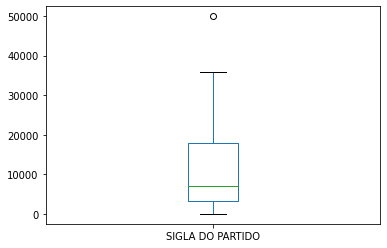

In [6]:
#filtrando por filiados com registro regular.
contagem_por_partido = df[df["SITUACAO DO REGISTRO"] == "REGULAR"]["SIGLA DO PARTIDO"].value_counts()

print(f"Filiados com Registro Regular por partido:\n\
MÉDIA: {round(contagem_por_partido.mean(),2)}\n\
VARIÂNCIA: {round(contagem_por_partido.var(),2)}\n\
DESVIO PADRÃO: {round(contagem_por_partido.std(),2)}\n\
MEDIANA: {round(contagem_por_partido.median(),2)}\n\
MODA: {round(contagem_por_partido.mode()[0],2)}")
# fazendo boxplot do dado
contagem_por_partido.plot.box();

### 3.1 Pergunta: no estado da Paraíba, qual o partido com a maior base de filiados atualmente? em que municípios este partido é mais expressivo?

,SIGLA DO PARTIDO,QUANTIDADE
6,PMDB,49925
0,DEM,35726
17,PSDB,33908
22,PT,29050
8,PP,25622


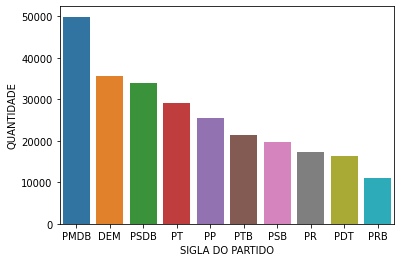

In [7]:
# Para entender melhor os dados
import seaborn as sns
filiados_por_partido = df\
  [df['SITUACAO DO REGISTRO'] == "REGULAR"]\
  .groupby(by=["SIGLA DO PARTIDO"])\
  .size()\
  .reset_index(name='QUANTIDADE')\
  .sort_values(by="QUANTIDADE", ascending=False)\
  .head(10)
  # .set_index('SIGLA DO PARTIDO')

sns.barplot(data=filiados_por_partido, x="SIGLA DO PARTIDO", y="QUANTIDADE")
filiados_por_partido.head(5)

Fica bem claro que o partido com a maior base de filiados na paraíba é o PMDB, com o democratas em segundo lugar. o que mostra que o estado tem uma predileção por partidos de **centro-direita**.

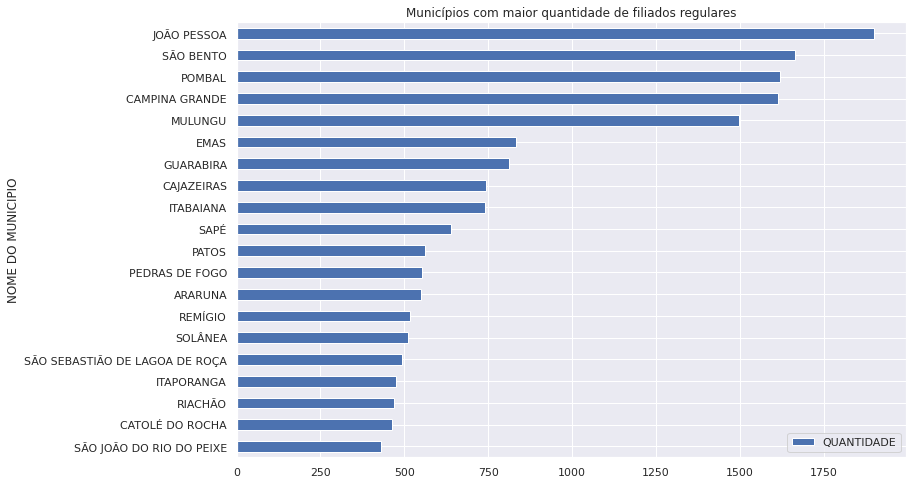

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt


filiados_por_municipio = df\
  [(df['SITUACAO DO REGISTRO'] == "REGULAR") \
   & (df['SIGLA DO PARTIDO'] == "PMDB")]\
  .groupby(by=["NOME DO MUNICIPIO"])\
  .size()\
  .reset_index(name='QUANTIDADE')\
  .sort_values(by="QUANTIDADE", ascending=False)\
  .head(20)\
  .sort_values(by="QUANTIDADE", ascending=True)\
  .set_index("NOME DO MUNICIPIO")\
  


filiados_por_municipio.plot.barh(title="Municípios com maior quantidade de filiados regulares", label="Quantidade de Filiados");

Com isso, podemos observar que os municípios onde o PMDB possui maior número de filiados é na capital de **JOÃO PESSOA** e no município de **São Bento.**

### 3.2 Pergunta: Existem Picos de Registros de Filiação em partidos durante períodos de troca de poder? (Eleições)

Transformando os dados em uma série temporal, indexados por data de filiação, podemos observar o seguinte padrão: existem picos ocrorência de filiação nos 


meses de outubro de 1999, 2003, 2007, 2011, 2015. o que coincide com o mês das eleições presidenciais.

DATA DA FILIACAO
2003-09    30062
2007-09    21626
1999-09    16850
2015-09    15047
2003-08    13338
2011-09    12840
dtype: int64


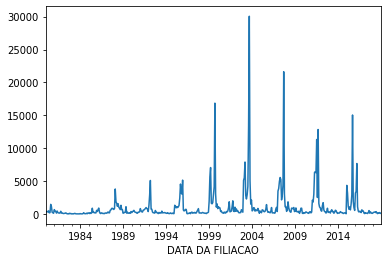

In [9]:
data_de_filiacao = df\
.set_index("DATA DA FILIACAO")\
.loc['1980-01-01':'2020-12-31']\
.groupby(pd.Grouper(freq='M'))\
.size();

data_de_filiacao.plot();
data_de_filiacao.index = data_de_filiacao.index.strftime("%Y-%m")
print(data_de_filiacao.sort_values(ascending=False).head(6))

Refinando mais o escopo de pesquisa à nível de semanas dentre os meses entr 2002 e 2004, podemos ver que esse pico se concentra nas semanas próximos às eleições.

DATA DA FILIACAO
September 28 2003 - Semana 38    12642
October 05 2003 - Semana 39       9267
September 21 2003 - Semana 37     7014
March 16 2003 - Semana 10         5868
August 24 2003 - Semana 33        5130
dtype: int64

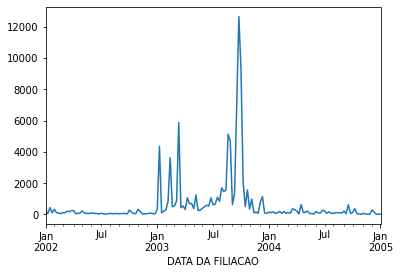

In [10]:
data_de_filiacao = df\
.set_index("DATA DA FILIACAO")\
.loc['2002-01-01':'2004-12-31']\
.groupby(pd.Grouper(freq='W'))\
.size();

data_de_filiacao.plot();
data_de_filiacao.index = data_de_filiacao.index.strftime("%B %d %Y - Semana %W")
data_de_filiacao.sort_values(ascending=False).head(5)


A Resposta para essa pergunta é **sim**, 
em períodos próximos às eleições, existem grandes picos nos números de novos filiados em partidos.

### 3.3 Pergunta: Existem Picos/Anomalias em relação à cancelamentos de registro de filiado? são registrados picos de cancelamento ocorrido por via judicial?

Agrupando os dados em relação à quantidade de registros por data de cancelamento, temos o seguinte gráfico:

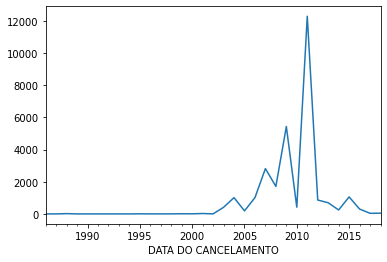

In [11]:
a = df.set_index("DATA DO CANCELAMENTO")\
.loc['1980-01-01':'2020-12-31']\

a[a['MOTIVO DO CANCELAMENTO'] == 'Judicial']\
.groupby(pd.Grouper(freq='Y'))\
.size()\
.plot()
# .groupby("SIGLA DO PARTIDO")\
# .size()\
# .sort_values(ascending=False)

É Visto que a quantidade de cancelamento não segue os mesmos padrão dos cíclos de inscrições. é observável um grande pico de cancelamentos entre os anos 2010 e 2013.

Precisamos afunilar o nosso dataset e agrupando nossos dados em clusters em relação à expressividades desses partidos.

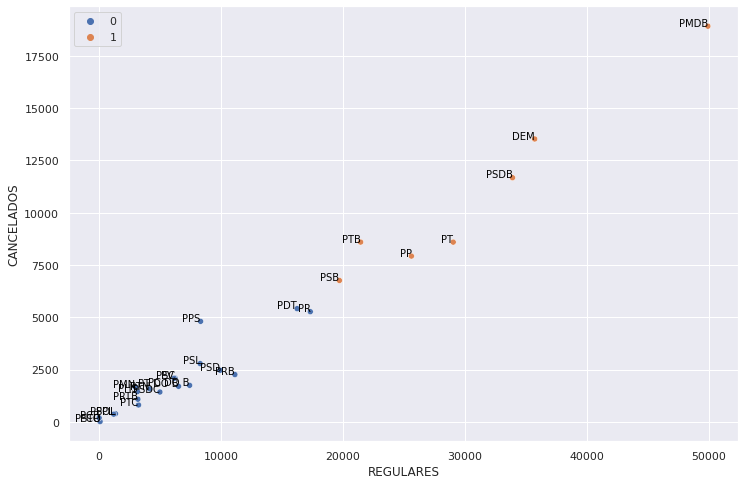

In [12]:
from sklearn.cluster import KMeans
import seaborn as sns

# gerar tabela de agrupamento de registros por siglas de partido
registro = pd.DataFrame()
registro['REGULARES'] = df[df['SITUACAO DO REGISTRO'] == 'REGULAR']['SIGLA DO PARTIDO'].value_counts()
registro['CANCELADOS'] = df[df['SITUACAO DO REGISTRO'] == 'CANCELADO']['SIGLA DO PARTIDO'].value_counts()
registro['DESFILIADOS'] = df[df['SITUACAO DO REGISTRO'] == 'DESFILIADO']['SIGLA DO PARTIDO'].value_counts()
registro['CANCELADOS/DESFILIADOS'] = df[df['SITUACAO DO REGISTRO'].isin(['CANCELADO', 'DESFILIADO'])]['SIGLA DO PARTIDO'].value_counts()
df_group = registro[['REGULARES','CANCELADOS/DESFILIADOS']]

kmeans = KMeans(n_clusters=2)
kmeans.fit(df_group)

sns.set(rc={'figure.figsize':(12,8)})

p1 = sns.scatterplot(data=registro, x='REGULARES', y='CANCELADOS',  hue=kmeans.labels_)

for line in range(0,registro.shape[0]):
  p1.text(registro['REGULARES'][line]+10, 
          registro['CANCELADOS'][line], registro.index[line], horizontalalignment='right', 
  size='small', color='black', weight='regular')

Também é notável que esses pontos de dados seguem uma regressão linear.

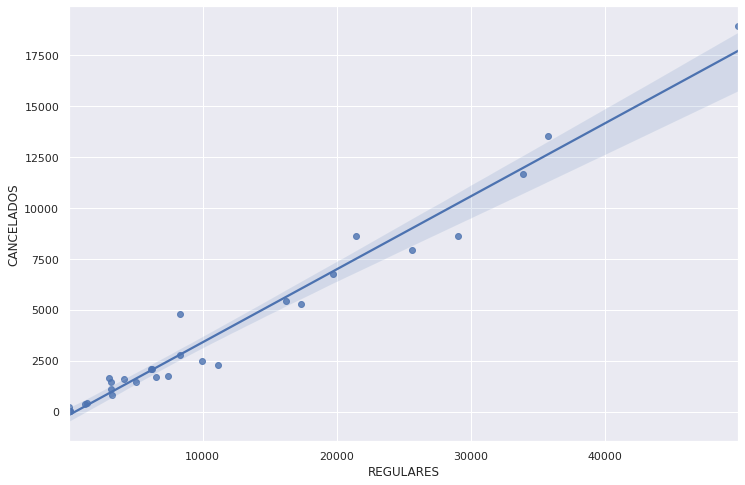

In [13]:
sns.regplot(data=registro, x='REGULARES', y='CANCELADOS');

Ao Clusterizar os dados em dois grupos em relação a sua expressividade no registro, temos dois grupos:

In [14]:
# mapeando os clusters criados

cluster_map = pd.DataFrame()
cluster_map['partido'] = registro.index.values
cluster_map['cluster'] = kmeans.labels_

print(f"""
Partidos no Grupo 0 (Maior Significância) - {cluster_map[cluster_map['cluster'] == 0]['partido'].values}


Partidos no Grupo 1: (Menor Significância) - {cluster_map[cluster_map['cluster'] == 1]['partido'].values}
""");


Partidos no Grupo 0 (Maior Significância) - ['PR' 'PDT' 'PRB' 'PSD' 'PPS' 'PSL' 'PC DO B' 'PT DO B' 'PSC' 'PV' 'PSDC'
 'PTN' 'PTC' 'PRTB' 'PHS' 'PMN' 'PSOL' 'PPL' 'PCO' 'PSTU' 'PCB']


Partidos no Grupo 1: (Menor Significância) - ['PMDB' 'DEM' 'PSDB' 'PT' 'PP' 'PTB' 'PSB']



A Maior parte dos cancelamentos são à pedido do eleitor, mas para responder essa pergunta focaremos na questão Judicial.

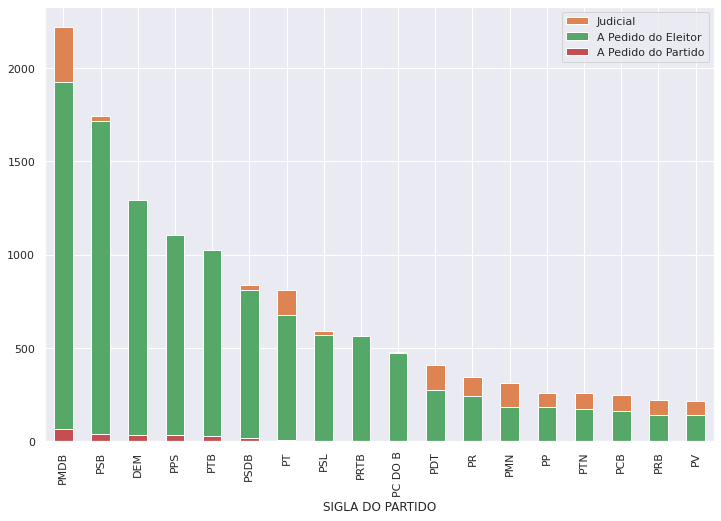

In [15]:
a = df.set_index("DATA DO CANCELAMENTO")\
.loc['2010-01-01':'2012-12-31']

a[(a['MOTIVO DO CANCELAMENTO'] == 'Judicial')]\
.groupby("SIGLA DO PARTIDO")\
.size()\
.sort_values(ascending=False)\
.plot(kind="bar", stacked=True, legend=True, label="Judicial", color='C1')

a[(a['MOTIVO DO CANCELAMENTO'] == 'A pedido do eleitor')]\
.groupby("SIGLA DO PARTIDO")\
.size()\
.sort_values(ascending=False)\
.plot(kind="bar", stacked=True, color='C2', legend=True, label='A Pedido do Eleitor');

a[(a['MOTIVO DO CANCELAMENTO'] == 'A pedido do partido')]\
.groupby("SIGLA DO PARTIDO")\
.size()\
.sort_values(ascending=False)\
.plot(kind="bar", stacked=True, color='C3', legend=True,label='A Pedido do Partido');

Filtrando o gráfico de cancelamentos por data de 2010 à 2013 com apenas os partidos de maior relevância

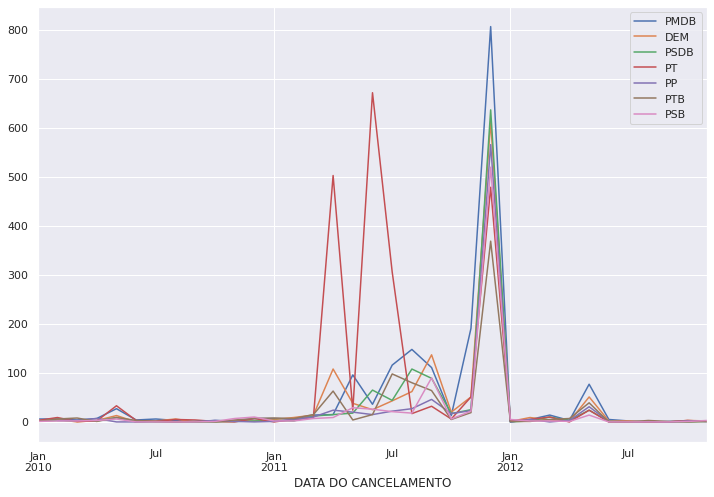

In [16]:
a = df.set_index("DATA DO CANCELAMENTO")\
.loc['2010-01-01':'2012-12-31']

for partido in ['PMDB','DEM','PSDB','PT','PP','PTB','PSB']:
  a[(a['MOTIVO DO CANCELAMENTO'] == 'Judicial') & (a['SIGLA DO PARTIDO'] == partido)]\
  .groupby(pd.Grouper(freq='M'))\
  .size()\
  .plot(kind='line',label=partido, legend=True)

Filtrando pelos partidos DEM, PT e PSDB, podemos identificar grandes picos de cancelamentos judiciais durante o ano de 2011. com a maior expressividade vinda desses partidos.

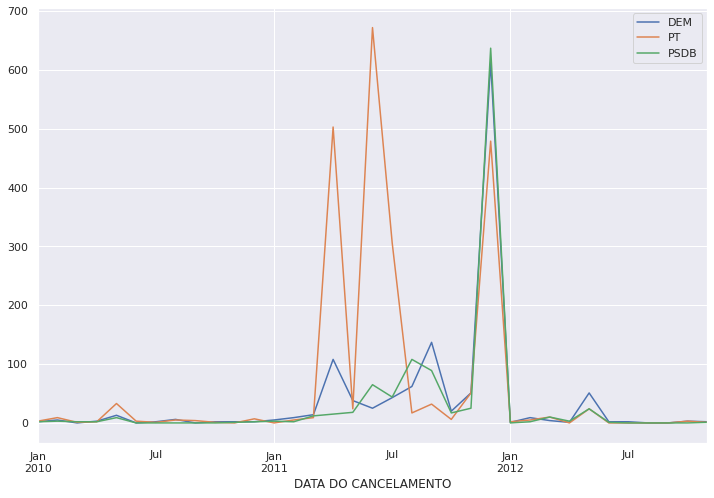

In [17]:
a = df.set_index("DATA DO CANCELAMENTO")\
.loc['2010-01-01':'2012-12-31']

for partido in ['DEM','PT','PSDB']:
  a[(a['MOTIVO DO CANCELAMENTO'] == 'Judicial') & (a['SIGLA DO PARTIDO'] == partido)]\
  .groupby(pd.Grouper(freq='M'))\
  .size()\
  .plot(kind='line',label=partido, legend=True)

Podemos também calcular a dispersão  dos cadastros cancelados á pedido do Eleitor 

In [18]:
#Gráfico de Dispersão  dos Cadastros Cancelados á Pedido do Eleitor 


cancelados = filiados_paraiba\
  [(filiados_paraiba['SITUACAO DO REGISTRO'] == "CANCELADO") &\
   (filiados_paraiba['MOTIVO DO CANCELAMENTO'] == "A pedido do eleitor")]\
  .groupby(by=["SIGLA DO PARTIDO", "DATA DO CANCELAMENTO"])\
  .size()\
  .reset_index(name='QUANTIDADE')\
  .sort_values(by="QUANTIDADE", ascending=False)\

cancelados['DATA DO CANCELAMENTO'] = pd.to_datetime(cancelados['DATA DO CANCELAMENTO'], errors='ignore');

cancelados = cancelados\
  [(cancelados['DATA DO CANCELAMENTO'].dt.year < 2019) &\
   (cancelados['DATA DO CANCELAMENTO'].dt.year > 1970 )]\
  .groupby(by=[cancelados["DATA DO CANCELAMENTO"].dt.year, "SIGLA DO PARTIDO"])\
  .size()\
  .reset_index(name="QUANTIDADE");

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data=cancelados, x="DATA DO CANCELAMENTO", y="QUANTIDADE",hue="SIGLA DO PARTIDO")

NameError: ignored

### Pergunta 3: Houveram picos de cancelamentos à pedido do eleitor durante os meses após o impeachment da Dilma Rousseff em 2016?

Podemos responder essa pergunta usando 

In [ ]:
a = df.set_index("DATA DO CANCELAMENTO")\
.loc['2016-08-30':'2016-10-30']\


for partido in ['PMDB','DEM','PSDB','PT','PP','PTB','PSB']:
  a[(a['MOTIVO DO CANCELAMENTO'] == 'A pedido do eleitor') & (a['SIGLA DO PARTIDO'] == partido)]\
  .groupby(pd.Grouper(freq='D'))\
  .size()\
  .plot(kind='line',label=partido, legend=True)

a.groupby("DATA DO CANCELAMENTO").size().sort_values(ascending=False).head(5)

Houveram sim alguns picos durante as semanas subsequentes do impeachment. especialmente no dia 15 de novembro, com um total de 336 cancelamentos.

## 4. Conclusão

Através desta análise, concluimos que existem sim picos na movimentação de filiação e desfiliação aos partidos políticos em momentos de instabilidade política, e também notamos que, regularmente a cada 4 anos, um ano antes da eleição presidencial, existe um pico de novas filiações. também foi descoberto que durante o período de 2015, houve um pico de desfiliações judiciais.

Os maiores desafios desta pesquisa vém do fato da indisponibilidade de dados mais atualizados e de erros na codificação dos dados originais, que exigem um trabalho maior de preparação.